In [33]:
import string

from keras import layers
from keras.models import Model

import cv2
import numpy as np
import os

import matplotlib.pyplot as plt


In [16]:
symbols = string.ascii_lowercase + string.ascii_uppercase + "0123456789"
num_symbols = len(symbols)

# Tamanho das imagens de entrada à RN
img_height = 30
img_width = 80
img_shape = (img_height, img_width, 1)

# Tamanho da palavra no captcha
size_word = 5

In [17]:
################################################################################################################
#
# Modelo
#
#    Geração da rede neural com base no Keras
#
################################################################################################################

def create_net():
    
    img = layers.Input(shape=img_shape) 
    
    # Convolução
    conv1 = layers.Conv2D(16, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', name='Conv_1')(img)    
    mp1 = layers.MaxPooling2D(padding='same', name='MaxPool_1')(conv1)
    
    # Convolução
    conv2 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros', name='Conv_2')(mp1)
    mp2 = layers.MaxPooling2D(padding='same', name='MaxPool_2')(conv2)
    
    # Convolução
    conv3 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros', name='Conv_3')(mp2)
    bn = layers.BatchNormalization()(conv3)
    
    # Camada de saída
    mp3 = layers.MaxPooling2D(padding='same', name='MaxPool_3')(bn) 
    flat = layers.Flatten()(mp3)
    
    outs = []
    for i in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, name='digit%d' % i, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile('adam', loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
    model.summary()
    return model


In [18]:
model = create_net()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 80, 1)]  0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 28, 78, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
MaxPool_1 (MaxPooling2D)        (None, 14, 39, 16)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 12, 37, 32)   4640        MaxPool_1[0][0]                  
____________________________________________________________________________________________

In [19]:
filePathName = './output-captcha/weights-50-4.75.hdf5'
model.load_weights(filePathName)

In [20]:
################################################################################################################
#
# Predição
#
#    Função que recebe um modelo e uma imagem captcha e retorna a string contida nela conforme determinado pelo
#    modelo.
#
################################################################################################################

def predict(net, img):
    
    word_predicted = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    word_predicted = np.reshape(word_predicted, (size_word, num_symbols))
    
    capt = ''
    for symbol in word_predicted:
        idx_symbol = np.argmax(symbol)
        capt += symbols[idx_symbol]
    
    return capt

In [21]:
################################################################################################################
#
# Leitura dos nomes dos arquivos
#
#    Realiza a leitura do nome dos arquivos de captchas recebendo por parametro o diretório onde os arquivos 
#    estão armazenados.
#    Retorna a lista do nome de arquivos.
#
################################################################################################################

def read_name_files(files_dir = 'images/dataset'):

    files = os.listdir(files_dir)
    
    return files

In [22]:
################################################################################################################
#
# Leitura das imagens em lote
#
#    Realiza a leitura das imagens captchas recebendo por parametro os símbolos que formam os captchas,
#    a lista dos nomes dos arquivos e o diretório onde os arquivos estão armazenados.
#    Retorna o dataset no formato X e y.
#
################################################################################################################

def read_dataset_batch(symbols, batch_files, captcha_dir = 'images/dataset'):
    
    n_samples = len(batch_files)
    
    X = np.zeros((n_samples, img_height, img_width, 1))
    y = np.zeros((size_word, n_samples, num_symbols))

    i = 0;
    
    # Leitura de cada arquivo
    for name_file in batch_files:
        
        img = cv2.imread(os.path.join(captcha_dir, name_file), cv2.IMREAD_GRAYSCALE)
        word = name_file[:-4] # retira a extensão .png
        
        # Se a palavra tem 5 caracteres
        if len(word) == size_word:
            
            img = img / 255. # Coloca o valor dos pixels entre 0 e 1
            
            # Faz o reshape da imagem para a metade do tamanho da altura e comprimento, reduzindo ela em 1/4 do tamanho
            img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
            
            # Matriz alvo, possui numero da caracteres na palavra por número de caracteres possíveis
            # Na matriz alvo se a posição corresponde a determinado símbolo o valor da célula será 1, 
            # e 0 caso contrário.
            targs = np.zeros((size_word, num_symbols))
            
            for idx_letter, simbol in enumerate(word):
                n_simbol = symbols.find(simbol)
                targs[idx_letter, n_simbol] = 1
                
            X[i] = img
            y[:, i] = targs
            
            i = i +1;
            
            # Controle de progresso
            if(i%5000 == 0):
                print(str(i) + " imagens read");

    return X, y

In [27]:
#Read Dataset
name_dir_test = 'images/dataset_test';
name_captcha_files_test = read_name_files(files_dir = name_dir_test)
print('Número de imagens no dataset teste: ' + str(len(name_captcha_files_test)))

X_test, y_test = read_dataset_batch(symbols, name_captcha_files_test, captcha_dir = name_dir_test)


Número de imagens no dataset teste: 19976
5000 imagens read
10000 imagens read
15000 imagens read


Sv8D9


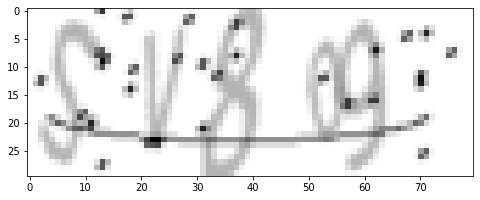

In [36]:
# Predict
img = X_test[0,:,:]
print(predict(model, img))

fig = plt.figure(figsize=(8,15))
plt.imshow(img[:,:,0], cmap="gray")
plt.show()

(1, 4, 17, 32)


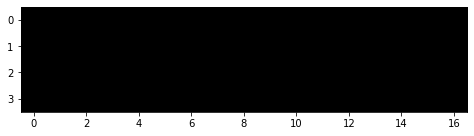

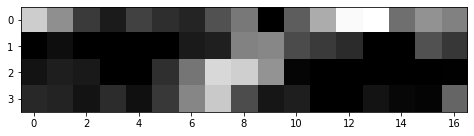

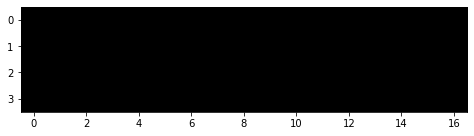

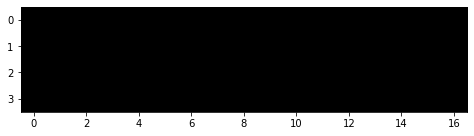

In [54]:
# Get Output Layers
# MaxPool_1
#layer_name = 'MaxPool_1'
layer_name = 'Conv_3'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
features = intermediate_output = intermediate_layer_model.predict(img[np.newaxis, :, :, np.newaxis])

print(features.shape)
fig = plt.figure(figsize=(8,15))
plt.imshow(features[0,:,:,0], cmap="gray")
plt.show()

fig = plt.figure(figsize=(8,15))
plt.imshow(features[0,:,:,1], cmap="gray")
plt.show()

fig = plt.figure(figsize=(8,15))
plt.imshow(features[0,:,:,2], cmap="gray")
plt.show()

fig = plt.figure(figsize=(8,15))
plt.imshow(features[0,:,:,3], cmap="gray")
plt.show()

#print(features)
#Conv_3